# Model Training and Evaluation

This notebook focuses on model training and evaluation. The goal of this notebook is to explore different models and try to compare them. Additionally, this notebook aims to provide insights on why a model performs the way it does.

We will start first with transforming our data so that it is in a form that is suitable for training. Afterwhich, we will train the following models on the data:

1. MLP
2. Baseline CNN
3. Naive Deep CNN
4. CNN with Skip Connections
5. CNN with Skip Connections and Self Attention
6. Resnet with Pretrained Feature Extractor
7. Resnet with Retrained Feature Extractor

After training all the models we will evaluate them and draw some insights about the results. Finally, we will add in our conclusions and some possible future work we could do.

# IMPORTANT!!!

A lot of the models we will be exploring are quite deep and would therefore need a lot of memory. Aside from this, the training itself would take some time. It is therefore not recommended to train all these from scratch. It would be better to simply load the models that have previously been trained. While training shallow networks is a good start, this project would like to highlight the motivation behind certain architectures which would only be apparent if we use deep networks.

If one is really ineterested to retrain the models, set `use_checkpoint = False`.

In [1]:
use_checkpoint = True

Of course we want to make sure that the training code actually works without going through the trouble of retraining the whole thing until convergence. To help with this, code cells are included that runs each model but only over one epoch, with a batch size of 16 (to keep memory requirements low). If we don't want to do this minimal run however (because we trust the code) we can just set `run_minimal = True`. Note that the minimal models are not used. 

In [2]:
run_minimal = True

The files for the checkpoints be downloaded through this [link](https://drive.google.com/drive/folders/1IgyFq-4ZNj9XUlMD_IIE6aSB8VHXEJR4?usp=sharing). Ideally, all the files are downloaded with the folder name and structure retained for a seamless experience. The folders `saved_plots`, `saved_checkpoints` and `livestock` must be on the same level as this notebook. For the most straightforward usage, one can simply download the entire `Project Files` folder and run the notebook inside of it.

If exploring the effects of the hyperparameters is not of interest and the `saved_checkpoints` file is too big (it's more than 15GB) one can choose to download the `saved_checkpoints` inside `saved_checkpoints_minimal` folder instead. This contains only the best hyperparameters so the code would not work if the hyperparameters are changed.

## Importing Libraries

First let's import a couple of libraries that we will use here. We will explain some imports along the way when we encounter them.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary

from project_utils import ModelTrainer, evaluate_models, plot_train_stats, load_plot, get_checkpoint, show_sample_images, predict_image, show_activation
from project_models import BaselineMLP, BaselineCNN, NaiveDeepCNN, SkipCNN, SelfAttentionSkipCNN, ResnetModelPretrained, ResnetModelRetrained

## I. Transforming the data

Remember that in the previous notebook we only did some basic cleaning such as removing noise and duplicates. This is not enough to make our data suitable for training. The first reason is that the data is not yet normalized. Normalizing the data will allow for better training and convergence. The second reason is that the models we will explore here assume a specific image size. In particular we will assume an image size of 96x96 (as mentioned in the previous notebook) similar to the one used by Stanford's [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

### A. Normalizing the data
To transform the data we can use the torchvision package.  [Torchvision](https://pytorch.org/vision/stable/index.html) is a poweful tool for dealing with image data when training models. In particular we will use two capabilities it provides; `torchvision.transforms` and the `ImageFolder` function.

`ImageFolder` applies the transforms we specify in the `transform` argument and pairs the data with its corresponding label to form a torch `Dataset`. The only requirement here is for us to follow a directory structure with the root folder containing one folder for each of the class. This is extremely convenient for us because that's the way we downloaded our data in the previous notebook. The folder name for each class will also be its label. Another option is to create our own custom Dataset class if we need more flexibility, but here we don't need that so we'll stick with `ImageFolder`.

`torchvision.transforms` provide us with ways to morph our data. `transforms.Resize` for example allows us to change our image size to the dimensions that we want while `transforms.ToTensor` converts the passed image to a tensor which is the datatype we deal with when training. The transforms are generally self-explanatory so it's easy to understand what each one does. If we want a transform that applies a group of transforms one after the other, we can simply use `transforms.Compose` and pass in the list of transforms we want to use.


`transforms.Normalize` also exists but to use it we need our data statistics: mean and standard deviation for each channel. As such, we will have to compute for these values. 

In [4]:
train_dataset_path = "livestock/train"
val_dataset_path = "livestock/validation"
test_dataset_path = "livestock/test"

In [5]:
# we only need these two transforms for now since we'll just use this dataset to
# comopute the batch statistics for normalization
mean_transforms = transforms.Compose([
    transforms.Resize((96,96)), 
    transforms.ToTensor(),
])

In [6]:
mean_dataset = ImageFolder(root = train_dataset_path, transform = mean_transforms)
# This dictionary stores the mapping from the index label to the actual class label
class_dict = mean_dataset.classes

After we have a torch `Dataset`, we can then simply pass it in to torch `DataLoader` which will allow us to seamlessly iterate through our dataset in batches. This is handy in training and in this case where we want to compute the group statistics.

Also, note that we are only loading in our train dataset. The reason for this is because when we are creating our statistics, we want to treat both the validation set and the test set as invisible or non-existent. The thinking here is that the train dataset must be treated as representative of our entire dataset. At any part of our training we also don't want to leak information from our test and validation set.

In [7]:
mean_dataloader = DataLoader(mean_dataset, batch_size = 100)

Finally, we can compute our statistics, mean and standard deviation, for each channel. These are the information we need to be able to normalize our data.

In [8]:
mean_values = torch.Tensor([0, 0, 0])
n_elements = 0
for images, _ in mean_dataloader:
    mean_values += torch.sum(images, axis=[0,2,3])
    n_elements += images.shape[0] * images.shape[2] * images.shape[3]
mean_values = mean_values/n_elements

In [9]:
std_values = torch.Tensor([0, 0, 0])
for images, _ in mean_dataloader:
    std_values += torch.sum(torch.square(images - mean_values.view(1,-1,1,1)), axis=[0,2,3])
std_values = torch.sqrt(std_values/n_elements)

In [10]:
mean_values, std_values

(tensor([0.4695, 0.4534, 0.3787]), tensor([0.2366, 0.2309, 0.2434]))

### B. Data Augmentation
We can now load in our data and apply normalization to it. But to even make it better for our training, we will add additional transforms to our training set such as `transforms.RandomHorizontalFlip` and `transforms.RandomRotation`. These are data augmentation techniques that will allow our model to generalize better. The goal of these transforms is to teach the model that rotating images a bit or flipping them does not change its label. This will make the model more resilient to these types of invariances. For the test and validation set we won't apply these transforms as we only need these in training our model and not in evaluation.

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((96,96)), 
    transforms.RandomHorizontalFlip(0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values)
])

test_transforms = transforms.Compose([
    transforms.Resize((96,96)), 
    transforms.ToTensor(),
    transforms.Normalize(mean_values, std_values)
])

In [12]:
train_dataset = ImageFolder(root = train_dataset_path, transform = train_transforms)
val_dataset = ImageFolder(root = val_dataset_path, transform = test_transforms)
test_dataset = ImageFolder(root = test_dataset_path, transform = test_transforms)

### Visualizing the Transformed Data

Let's also quickly check how the transormed data looks like as a form of sanity check. Again the code for this function can be found in **project_utils.py**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  ['sheep', 'sheep', 'pig', 'pig', 'chicken', 'cow']


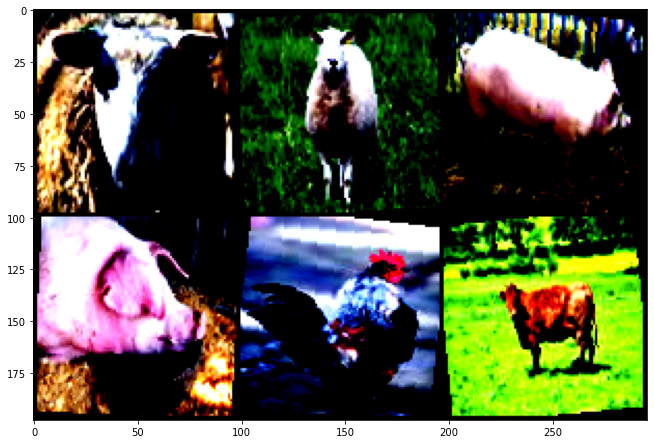

In [13]:
show_sample_images(train_dataset)

## II. Model Training

### Model Trainer

After transforming our data, we can now start training our models. Since we know we are going to train multiple models, we can create a helper class that abstracts away our training process. We will call this class `ModelTrainer`. Upon initialization, it stores the training and validation set. 

Using it is straightforward as it only has one function, `train_model`. This function accepts four arguments: the model we want to train and three hyperparameters (learning rate, number of epochs and batch size). The model will be trained with the given hyperparameters using the `Adam` optimizer and the `CrossEntropy` loss criterion. Upon finishing the training, it returns the trained model as well as some training statistics. Another helper function called `plot_train_stats` can be used to convert the returned statistics into a graph which will help us visualize the results and what happened during the training.

The code for this model and the other utility functions can be found under **project_utils.py**. 

In [14]:
trainer = ModelTrainer(train_dataset, val_dataset)

The code to create the model architecture can be found in **project_models.py**. We will however print the architecture and explain why each architechture was chosen. A good way to show other information about the architecture is using `torchsummary.summary`. This allows us to see the output shape and number of parameters per layer.

### Hyperparameter Tuning

In the following training steps we will immediately show which hyperparameters to use for each model. Setting these values is not random both in practice and in this project. A lot of time goes into hyperparameter tuning. For this project hyperparameter tuning was done by running each model on the possible combinations of `batch_size`=**[16, 32, 64]** and `learning_rate`=**[0.003, 0.0003, 0.00003]**. There are a total of 63 runs that were done (9 runs per model). The `num_epochs` was set to be **100** for all runs since we can simply check the graph where the training starts to overfit. Doing so will give us an idea of what the num_epochs must be set to.

Note that if `use_checkpoint = true` *changing the hyperparameters will also change the corresponding model that will be loaded*. However, please note that the *values that can be set are limited to the values mentioned above*. Using other values will lead to an error. Additionally, `num_epochs` does not have any effect when using saved models. The loaded model will always be using `num_epochs` = 100.

### A. MLP

The first model we will be exploring is the Multi Layer Perceptron or MLP. To use this model we will first flatten the image and treat each pixel as an input feature. We will then pass it through a couple of layers with each layer reducing the number of features. This is done until we only have six nodes which correspond to the probability that the image falls into each of the six classes. The hidden layers are activated by a ReLU which is empirically proven to be a good activation function for hidden layers to avoid gradient vanishing. We will also add Dropout for some regularization and [BatchNorm](https://arxiv.org/abs/1502.03167) to speed up convergence and help in training.

In [15]:
input_shape = (3, 96, 96)
summary(BaselineMLP().cuda(), input_shape)
print(BaselineMLP())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                 [-1, 1024]      28,312,576
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

Here, we notice that even though the layer is quite shallow, the number of parameters is already huge. This is because there is a unique parameter assigned to each input feature and output feature combination per layer. Because of this, an MLP is hard to scale as trying to make it go deeper (increasing the number of layers) or wider (increasing the hidden layer size) will make the number of parameters required increase drastically as well.

Let's train the model and see the results. 

In [16]:
learning_rate = 0.0003
num_epoch = 100
batch_size = 64

In [17]:
if run_minimal:
    trainer.train_model(BaselineMLP(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 1.586	 Train Acc: 0.372	 Val Loss: 1.343	 Val Acc: 0.495
Finished Training! Total time taken: 28.21


In [18]:
if use_checkpoint:
    baselineMLP = BaselineMLP()
    baselineMLP_chkpt = get_checkpoint("mlp", learning_rate, batch_size)
else:    
    baselineMLP, baselineMLP_stats = trainer.train_model(BaselineMLP(), lr=learning_rate, ne=num_epoch, bs=batch_size)

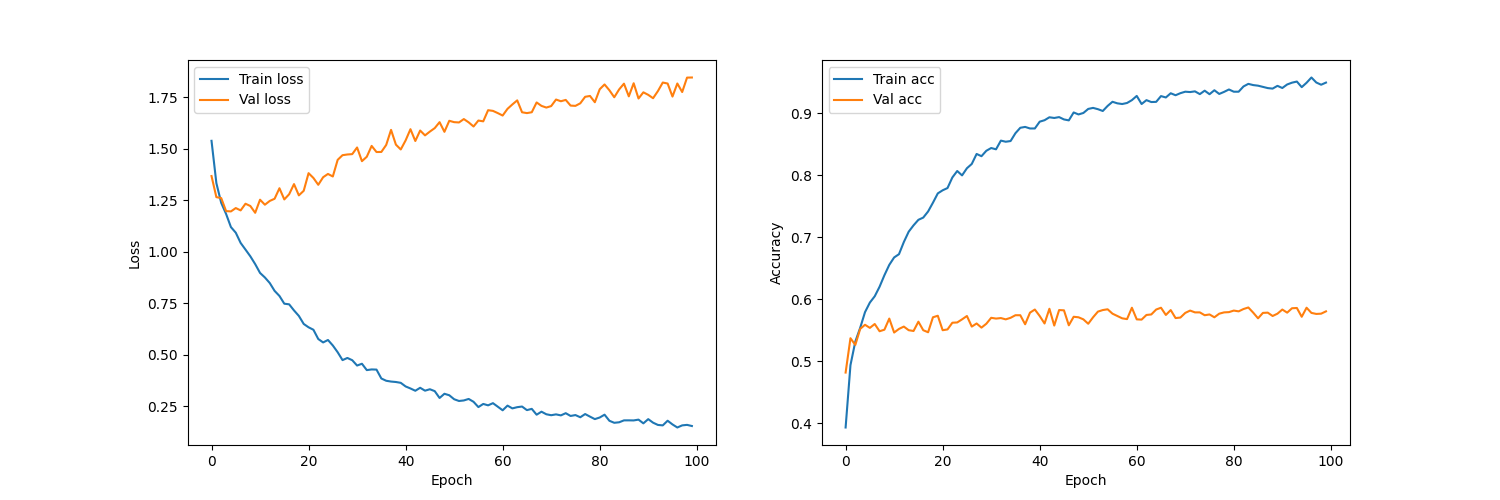

In [19]:
if use_checkpoint:
    x = load_plot("mlp", learning_rate, batch_size)
else:
    plot_train_stats(baselineMLP_stats)

While the model is better than a random guesser (which would have an accuracy of around 16.67%), it certainly is not good. The reason for this is that an MLP assumes a couple of things. First, it assumes that the image is always in the same place. Since each pixel is given its own unique weight, when an MLP is trained with a chicken at the center, the pixels corresponding to the center are trained to expect a chicken over there. If the chicken now appears on the left half, the MLP will not be able to tell that the image is a chicken. Second is that it assumes that each pixel is related to every other pixel in the image. MLP neglects the fact that often, only nearby pixels have a strong relationship with each other. Because of this, it tends to find a combination where all the pixels are taken into account. This leads to the problem of overfitting. The overfitting can easily be seen here when the training loss still decreases but the validation loss starts to increase.

### B. Baseline CNN

To be able to address the problems we encountered with MLP, we will switch out our model for a CNN. The way CNNs work is by using kernels, which can be visualized as rectangular patches that are slid across the image to generate a set of outputs. Since the kernels only account for inputs that it overlaps with at a given instance (receptive field), only pixels that are close together are considered. Additionally, the kernels are shared between receptive fields. This makes it so that if one kernel is trained to detect a snout, no matter where the snout is in the image, it will be recognized by the kernel.

Our `BasicConvBlock` is a Convolution followed by a BatchNorm and then a ReLU activation. After each block we will downsample the length and width by a factor of 2 with a MaxPool layer. Also, we will increase the number of kernels used at each layer to still retain a good amount of information even after downsampling. After the last convolution layer we will use aN adaptive average pool which condenses each output channel into a single scalar value (this can be thoughT of as aggregating global information). Finally a linear layer that maps these aggregated values to the probability of an image being in a class is used.

In [20]:
summary(BaselineCNN().cuda(), input_shape)
print(BaselineCNN())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
    BasicConvBlock-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
       BatchNorm2d-7          [-1, 128, 48, 48]             256
              ReLU-8          [-1, 128, 48, 48]               0
    BasicConvBlock-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
      BatchNorm2d-12          [-1, 256, 24, 24]             512
             ReLU-13          [-1, 256, 24, 24]               0
   BasicConvBlock-14          [-1, 256,

We can notice here that the number of parameters are much lower compared to the MLP. Again, this is because the kernels are shared between receptive fields. We also did not include any Dropout layers here as adding them did not seem to provide any benefits during testing. The model seems to not overfit and this may be becasue of the shared kernels which is in a way a form of regularization already.

In [21]:
learning_rate = 0.003
num_epoch = 100
batch_size = 16

In [22]:
if run_minimal:
    trainer.train_model(BaselineCNN(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 1.461	 Train Acc: 0.434	 Val Loss: 1.354	 Val Acc: 0.497
Finished Training! Total time taken: 15.57


In [23]:
if use_checkpoint:
    baselineCNN = BaselineCNN()
    baselineCNN_chkpt = get_checkpoint("cnn", learning_rate, batch_size)
else:
    baselineCNN, baselineCNN_stats = trainer.train_model(BaselineCNN(), lr=learning_rate, ne=num_epoch, bs=batch_size)

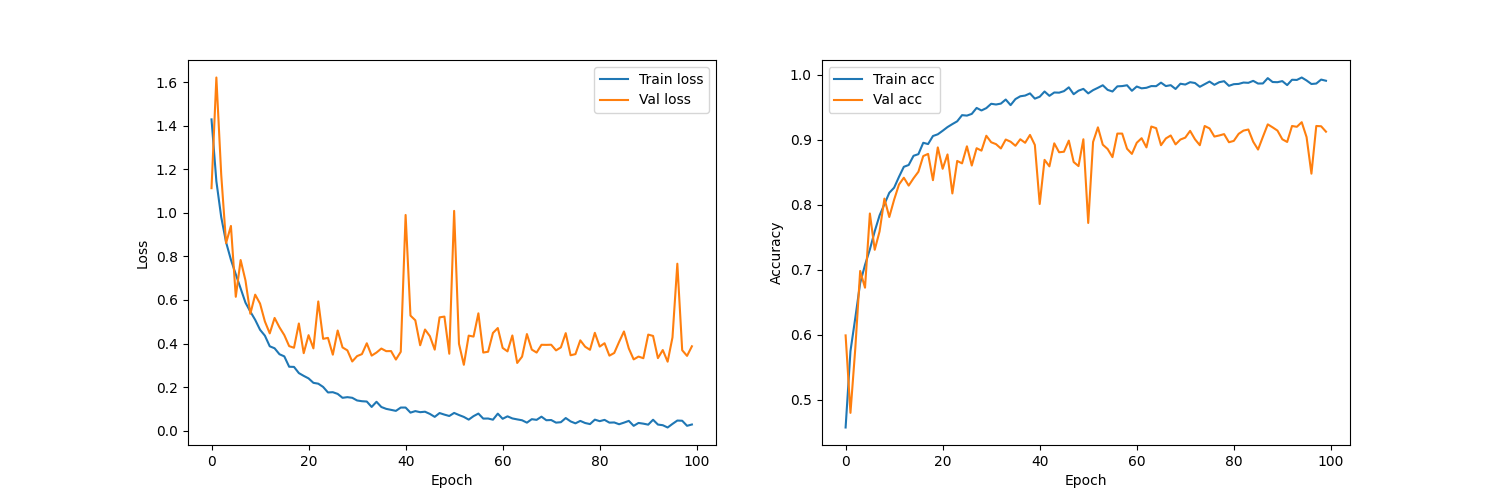

In [24]:
if use_checkpoint:
    load_plot("cnn", learning_rate, batch_size)
else:
    plot_train_stats(baselineCNN_stats)

The results of the CNN are definitely better than the MLP. In fact even with a shallow CNN the accuracy is already around 90%! This may mean that the number of layers in this model may already be enough to be able to identify the images correctly. In hindsight, it may have been better to make the CNN baseline even more shallow and narrow to further motivate the use of deeper and more sophisticated networks. 

One thing we can notice is that the training time per parameter took quite a hit. The reason for this is because even though there are less parameters being used by a CNN, it does more operations. The nature of convolution operations is that for each transition of the kernel to a new position, a new batch of operations are carried out. Since we are sliding it across the entire image, this will take a big number of operations to complete per kernel. Compare this to an MLP where for each output feature we simply need to do an operation on the input features once. But this is a consequence we cannot avoid and must accept if we want these kernels to be shared among the receptive fields.

### C. Naive Deep CNN

The baseline CNN provided very good results but let's still try to improve it. The most straightforward way to do this is by increasing the number of layers and making the network deeper. Doing so will increase the model capacity and hopefully allow more information to be extracted from the image. So let's just try to increase the number of layers and also make the network wider to see if it gets better.

In [25]:
summary(NaiveDeepCNN().cuda(), input_shape)
print(NaiveDeepCNN())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             256
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 96, 96]          36,928
       BatchNorm2d-5           [-1, 64, 96, 96]             128
              ReLU-6           [-1, 64, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]           4,160
       BatchNorm2d-8           [-1, 64, 96, 96]             128
              ReLU-9           [-1, 64, 96, 96]               0
 LayeredConvBlock-10           [-1, 64, 96, 96]               0
           Conv2d-11           [-1, 64, 96, 96]           4,160
      BatchNorm2d-12           [-1, 64, 96, 96]             128
             ReLU-13           [-1, 64, 96, 96]               0
           Conv2d-14           [-1, 64,

NaiveDeepCNN(
  (layers): Sequential(
    (0): LayeredConvBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (1): LayeredConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  

Notice here that we swapped out our `BasicConvBlock` with a `LayeredConvBlock`. Instead of doing just one 3x3 Convolution which the `BasicConvBlock` does, the `LayeredConvBlock` includes a 1x1 Convolution followed by a 3x3 Convolution and then another 1x1 Convolution. This is in a sense equivalent to two 3x3 Convolutions but we use this architechture here to save some space (we can see that two 1x1 Convolutions have less parameters than a single 3x3 convolution). Additionally, we stacked two `LayeredConvBlocks` before every downsampling. One last thing to note here is that we don't use any linear layers. We downsample until the output shape is 1x1 and then we use one final convolution to convert the output into 6 channels. Flattening this channel will provide the 6 values which represent the probability that the image falls into each class.

In [26]:
learning_rate = 0.0003
num_epoch = 100
batch_size = 32

In [27]:
if run_minimal:
    trainer.train_model(NaiveDeepCNN(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 1.812	 Train Acc: 0.203	 Val Loss: 1.918	 Val Acc: 0.206
Finished Training! Total time taken: 100.27


In [28]:
if use_checkpoint:
    naiveDeepCNN = NaiveDeepCNN()
    naiveDeepCNN_chkpt = get_checkpoint("naive_cnn", learning_rate, batch_size)
else:
    naiveDeepCNN, naiveDeepCNN_stats = trainer.train_model(NaiveDeepCNN(), lr=learning_rate, ne=num_epoch, bs=batch_size)

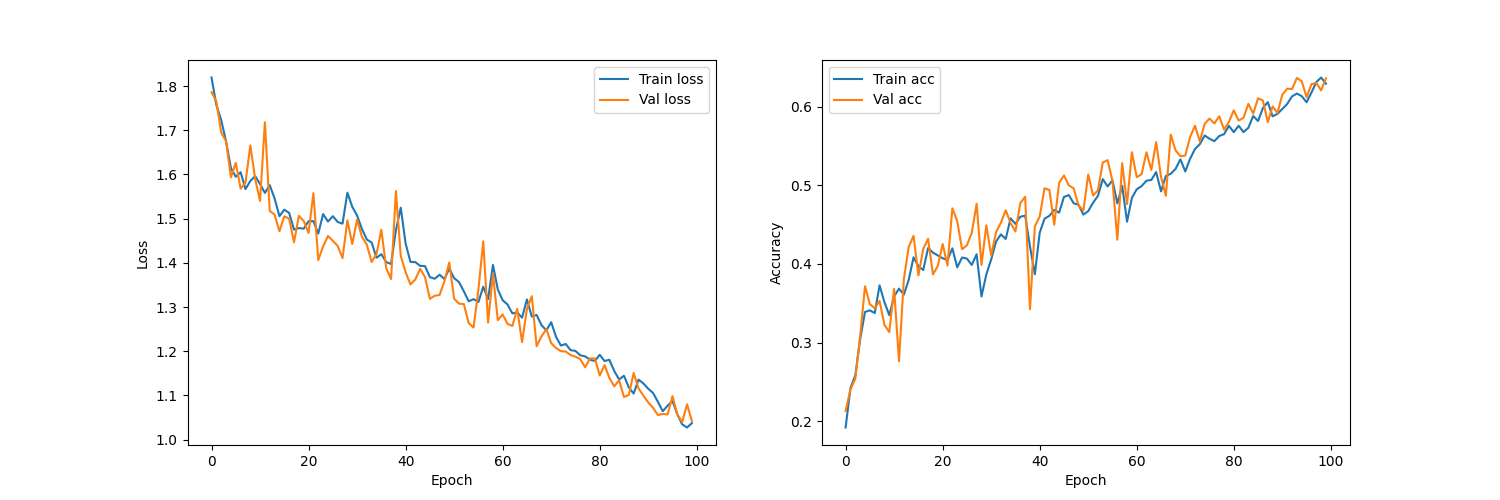

In [29]:
if use_checkpoint:
    load_plot("naive_cnn", learning_rate, batch_size)
else:
    plot_train_stats(naiveDeepCNN_stats)

As we went deeper and wider the training time increased a lot. But there's nothing suprising about that since we know that deeper and wider networks involve more operations. What is interesting however is that the model actually did worse compared to the shallow version. It was training very slowly and the loss was higher. The reason for this is because the deeper the network is, the harder it is to optimize. A lot more layers contribute to the loss and we need to try to tune them  simultaneously. Some of these layers might not be needed but it is hard to train the network to make these layers simply pass the input through without introducing any changes. This is what causes the bad performance we see when we naively increase the number of layers. We need to find a way to be able to make it easier for the network to "turn off" this unneeded layers so that the performance of the network is still good.

### D. Skip CNN

A good way to be able to solve the problem of learning in deep networks is by adding skip connections. These skip connections basically just pass the input to the output. The way this helps is that skip connections allow us to "short circuit" or in a sense "turn off" some of the convolution layers in case they are not needed. Since the output of each layer is a sum of the input and the transformed input, if the transformed input is not too helpful for the model, it is trained to have low values making the layer output be approximately equal to the input.

In [30]:
summary(SkipCNN().cuda(), input_shape)
print(SkipCNN())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             192
            Conv2d-2           [-1, 64, 96, 96]             256
       BatchNorm2d-3           [-1, 64, 96, 96]             128
              ReLU-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]          36,928
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]           4,160
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
 LayeredConvBlock-11           [-1, 64, 96, 96]               0
    SkipConvBlock-12           [-1, 64, 96, 96]               0
         Identity-13           [-1, 64, 96, 96]               0
           Conv2d-14           [-1, 64,

SkipCNN(
  (layers): Sequential(
    (0): SkipConvBlock(
      (identity): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): LayeredConvBlock(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU()
        )
      )
    )
    (1): SkipConvBlock(
      (identity): Identity()
      (conv): LayeredConvBlock(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=sam

All we did here was swap out our `LayeredConvBlocks` with `SkipConvBlocks`. The only difference between the two blocks is that for `SkipConvBlocks` the forward function includes adding the input to the output of a `LayeredConvBlock`. If the channel size increases, we first pass the input to a single Convolution layer with no bias and then add this to the output of the `LayeredConvBlock`.

In [31]:
learning_rate = 0.0003
num_epoch = 30
batch_size = 16

In [32]:
if run_minimal:
    trainer.train_model(SkipCNN(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 1.673	 Train Acc: 0.472	 Val Loss: 1.136	 Val Acc: 0.603
Finished Training! Total time taken: 104.54


In [33]:
if use_checkpoint:
    skipCNN = SkipCNN()
    skipCNN_chkpt = get_checkpoint("skip_cnn", learning_rate, batch_size)
else:
    skipCNN, skipCNN_stats = trainer.train_model(SkipCNN(), lr=learning_rate, ne=num_epoch, bs=batch_size)

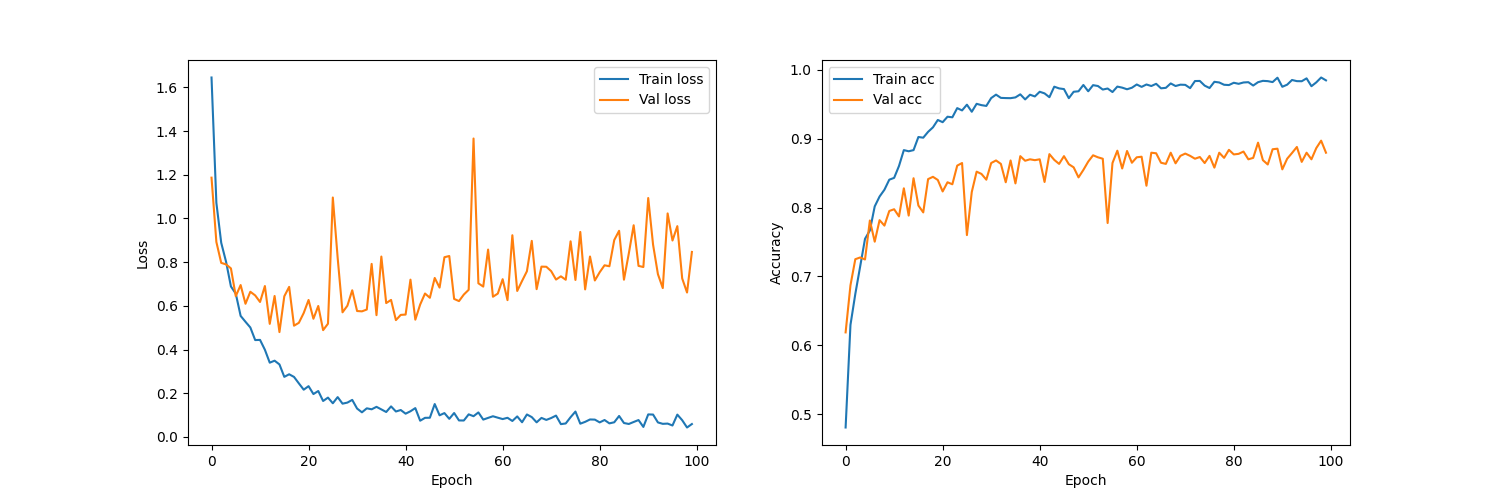

In [34]:
if use_checkpoint:
    load_plot("skip_cnn", learning_rate, batch_size)
else:
    plot_train_stats(skipCNN_stats)

With the use of skip connection, we were now able to train our model such that its results are again in the same ballpark as our baseline CNN. This shows us that skip connections are really helpful in training deep networks. Note that at hyperparameter configurations where the training does not diverge, the loss is consistently less than the naive deep CNN.

### E. Self Attention Skip CNN

Making the layer deeper is just one possible way the model can be improved. Another is by adding an *attention mechanism*. The intuition behind the attention mechanism is that when identifying an image, we need to focus on certain pixels more as they provide more information. A good example might be the head of the animal must be given more attention compared to the background. The SelfAttentionBlock tries to give emphasis on these important pixels while at the same time attenuating the influence of pixels that are not that relevant for classification.

Here we will replace some of the `SkipConvBlock` of the `SkipCNN` with `SelfAttentionBlocks`. In theory we can just insert `SelfAttentionBlocks` and not remove the other existing blocks but this would cause our model size to grow a lot (my machine for instance cannot accomodate simply adding attention blocks).

The `SelfAttentionBlock` used here is derived from the self attention block used in [SAGAN](https://arxiv.org/pdf/1805.08318.pdf). We start by mapping the input into three new feature spaces using three 2D Convolutions. This will give us three matrices which we will call the query, key and value respectively. The attention score for each pixel to every other pixel is then computed by doing a matrix multiplication between the query and value matrix. The result is then fed to a softmax and then multiplied to the value matrix. Finally we scale the result with a learnable scalar parameter (gamma) and then add it to the input x. In a way this still has a skip connection as when the attention part is not needed, the network can learn to decrease gamma so that the ouput is going to be approximately equal to the input. It is good to note that the memory issue introduced by the `SelfAttentionBlock` is not mainly caused by the number of parameters it needs but rather by the batch matrix multiplication step.

In [35]:
summary(SelfAttentionSkipCNN().cuda(), input_shape)
print(SelfAttentionSkipCNN())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             192
            Conv2d-2           [-1, 64, 96, 96]             256
       BatchNorm2d-3           [-1, 64, 96, 96]             128
              ReLU-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]          36,928
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]           4,160
       BatchNorm2d-9           [-1, 64, 96, 96]             128
             ReLU-10           [-1, 64, 96, 96]               0
 LayeredConvBlock-11           [-1, 64, 96, 96]               0
    SkipConvBlock-12           [-1, 64, 96, 96]               0
         Identity-13           [-1, 64, 96, 96]               0
           Conv2d-14           [-1, 64,

SelfAttentionSkipCNN(
  (layers): Sequential(
    (0): SkipConvBlock(
      (identity): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): LayeredConvBlock(
        (layers): Sequential(
          (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU()
        )
      )
    )
    (1): SkipConvBlock(
      (identity): Identity()
      (conv): LayeredConvBlock(
        (layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)

Here we are still using the same architechture of the `SkipCNN` but with each of the second `SkipConvBlocks` replaced with a `SelfAttentionBlock`.

In [36]:
learning_rate = 0.0003
num_epoch = 100
batch_size = 16

In [37]:
if run_minimal:
    trainer.train_model(SelfAttentionSkipCNN(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 1.355	 Train Acc: 0.527	 Val Loss: 1.094	 Val Acc: 0.613
Finished Training! Total time taken: 98.71


In [38]:
if use_checkpoint:
    saSkipCNN = SelfAttentionSkipCNN()
    saSkipCNN_chkpt = get_checkpoint("sa_cnn", learning_rate, batch_size)
else:
    saSkipCNN, saSkipCNN_stats = trainer.train_model(SelfAttentionSkipCNN(), lr=learning_rate, ne=num_epoch, bs=batch_size)

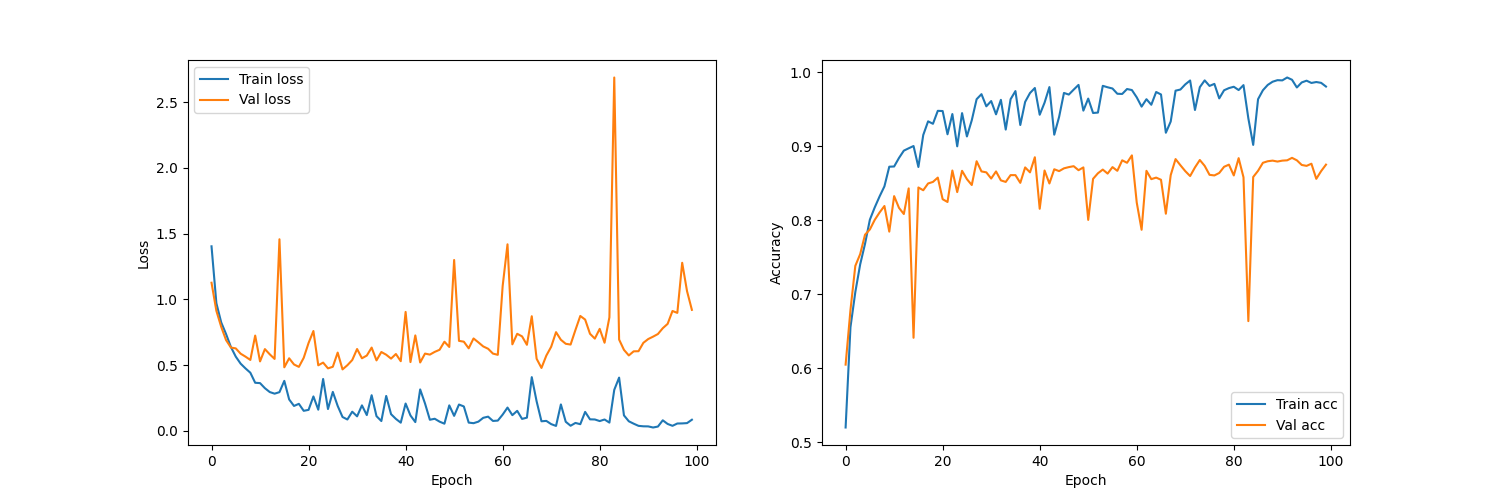

In [39]:
if use_checkpoint:
    load_plot("sa_cnn", learning_rate, batch_size)
else:
    plot_train_stats(saSkipCNN_stats)

This shows us good results similar to our SkipCNN. Interestingly, there are instances where the loss suddenly spikes a lot. While this may be because of the hyperparameters used (these were the hyperparameters that provided the best results among those tested) it is also possible that our network is more unstable. This may be because in our `SelfAttentionBlocks` we didn't use `BatchNorm` since we did a vanilla implementation of the attention mechanism. `BatchNorm` normalizes the output so that the gradient updates aren't too drastic and are much more controlled. Removing it might have reduced some stability. Nonetheless, the final results still turned out great.

### F. Pretrained Resnet

Finally, we will try to take a look at models made by the experts. In particular, here we will look at [Resnet152](https://arxiv.org/abs/1512.03385). First let's try freezing the feature extractor and training only the last linear layer. This is also called *transfer learning* as we are transferring the knowledge and learned features of the model in its previous task (learning over ImageNet) to our task. This model works by extracting a pre-defined set of features it has determined helpful when training over ImageNet and then try to find a combination of these extracted features through the last linear layer in such a way that we are able to determine what type of farm animal the image is.

In [40]:
summary(ResnetModelPretrained().cuda(), input_shape)
print(ResnetModelPretrained())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,096
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,384
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

ResnetModelPretrained(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

As a quick sanity check, we can see here that the number of trainable parameters is equal to the number of parameters in the final linear layer. This means that we are really not changing the values of our feature extractor.

In [41]:
learning_rate = 0.0003
num_epoch = 100
batch_size = 64

In [42]:
if run_minimal:
    trainer.train_model(ResnetModelPretrained(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 0.949	 Train Acc: 0.713	 Val Loss: 0.683	 Val Acc: 0.830
Finished Training! Total time taken: 34.65


In [43]:
if use_checkpoint:
    resnetPretrained = ResnetModelPretrained()
    resnetPretrained_chkpt = get_checkpoint("resnet_pretrained", learning_rate, batch_size)
else:
    resnetPretrained, resnetPretrained_stats = trainer.train_model(ResnetModelPretrained(), lr=learning_rate, ne=num_epoch, bs=batch_size)

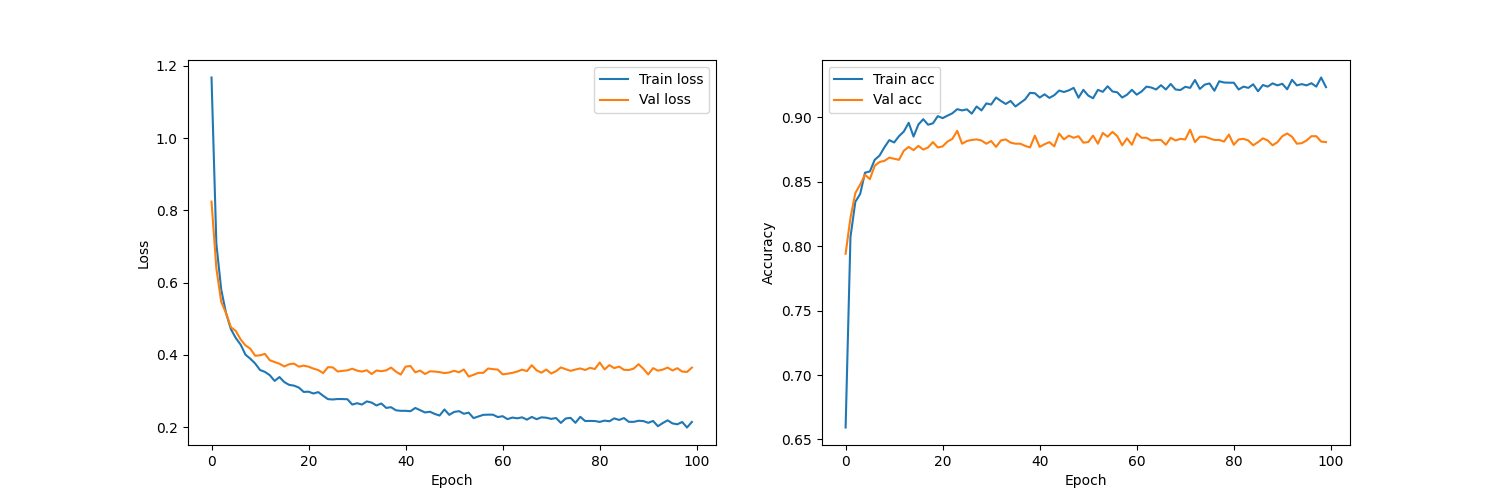

In [44]:
if use_checkpoint:
    load_plot("resnet_pretrained", learning_rate, batch_size)
else:
    plot_train_stats(resnetPretrained_stats)

### G. Retrained Resnet

We can also choose not to freeze the feature extractor. Doing this would allow it to be able to adjust the features it finds or find entirely new features specific to our image classification task. An upside to using the pretrained weights as our starting value is that if some of the features it extracts are useful they may be retained. This also assures that the initialization of the kernels will be some meaningful feature extractor instead of random values which speeds up convergence.

In [45]:
summary(ResnetModelRetrained().cuda(), input_shape)
print(ResnetModelRetrained())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,096
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,384
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

ResnetModelRetrained(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

Now we can see here that the number of trainable parameters is equal to the number of total parameters. This means we are now changing the values and re-training the feature extractor.

In [46]:
learning_rate = 0.00003
num_epoch = 100
batch_size = 64

In [47]:
if run_minimal:
    trainer.train_model(ResnetModelRetrained(), lr=learning_rate, ne=1, bs=16)

Epoch 1 	 Train Loss: 0.740	 Train Acc: 0.756	 Val Loss: 0.422	 Val Acc: 0.924
Finished Training! Total time taken: 91.55


In [48]:
if use_checkpoint:
    resnetRetrained = ResnetModelRetrained()
    resnetRetrained_chkpt = get_checkpoint("resnet_retrained", learning_rate, batch_size)
else:
    resnetRetrained, resnetRetrained_stats = trainer.train_model(ResnetModelRetrained(), lr=learning_rate, ne=num_epoch, bs=batch_size)

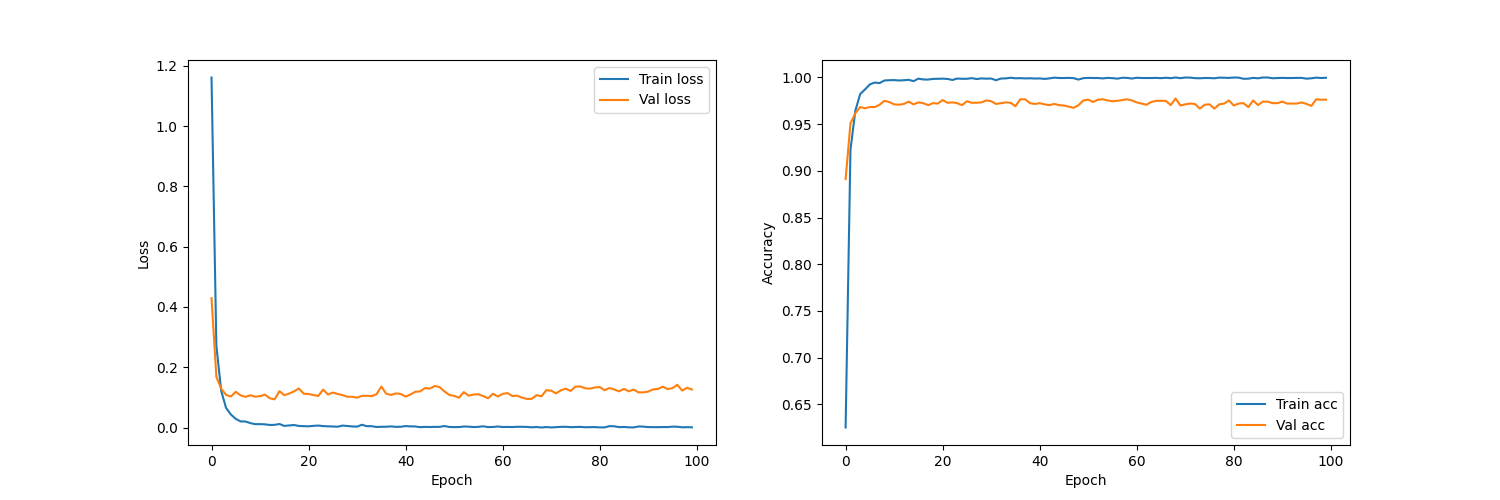

In [49]:
if use_checkpoint:
    load_plot("resnet_retrained", learning_rate, batch_size)
else:
    plot_train_stats(resnetRetrained_stats)

As we can see the Retrained Resnet provided extremely good results. This is because the initial values it used for its kernels were already good but on top of that it was even fine-tuned for our task. 

We can learn a couple of things from the network architecture of Resnet when we compare it to our SkipCNN architecture. First, we don't always have to do an activation after a convolution. It can be a good idea to simply do a couple of convolutions followed by `BatchNorm` and then activate it only once in a while. Second, it may be better to focus on making the network deeper while it is still narrow and only use a few layers when it is already wide. In our SkipCNN architecture the number of layers for after each downsampling was more or less the same while in Resnet the number of layers in the middle portion of the network were far higher than the one at the end.  

## III. Model Evaluation

In our training we only evaluated the models on the validation set. While this gives us a good idea of the model performance we cannot base our evaluation solely on this. The reason is because when we tuned our hyperparameters, it was based on the results of our validation set. This means that our validation set had some form of influence to our training. Again when we do our final evaluation we want the test set to have no influence at all on the training. We will therefore use our test set to do our final evaluation. This ensure that our final evaluation is as bias-free as possible.

MLP has f1 scores of {'chicken': 0.64, 'cow': 0.638, 'duck': 0.721, 'goat': 0.399, 'pig': 0.601, 'sheep': 0.525}
MLP has an accuracy score of 58.54%

BaselineCNN has f1 scores of {'chicken': 0.96, 'cow': 0.91, 'duck': 0.967, 'goat': 0.817, 'pig': 0.906, 'sheep': 0.871}
BaselineCNN has an accuracy score of 90.42%

NaiveDeepCNN has f1 scores of {'chicken': 0.863, 'cow': 0.624, 'duck': 0.686, 'goat': 0.377, 'pig': 0.623, 'sheep': 0.527}
NaiveDeepCNN has an accuracy score of 61.58%

SkipCNN has f1 scores of {'chicken': 0.942, 'cow': 0.891, 'duck': 0.949, 'goat': 0.754, 'pig': 0.867, 'sheep': 0.844}
SkipCNN has an accuracy score of 87.58%

SelfAttentionSkipCNN has f1 scores of {'chicken': 0.928, 'cow': 0.898, 'duck': 0.937, 'goat': 0.75, 'pig': 0.87, 'sheep': 0.842}
SelfAttentionSkipCNN has an accuracy score of 87.29%

ResnetPretrained has f1 scores of {'chicken': 0.941, 'cow': 0.885, 'duck': 0.949, 'goat': 0.787, 'pig': 0.891, 'sheep': 0.844}
ResnetPretrained has an accuracy score of 88.33

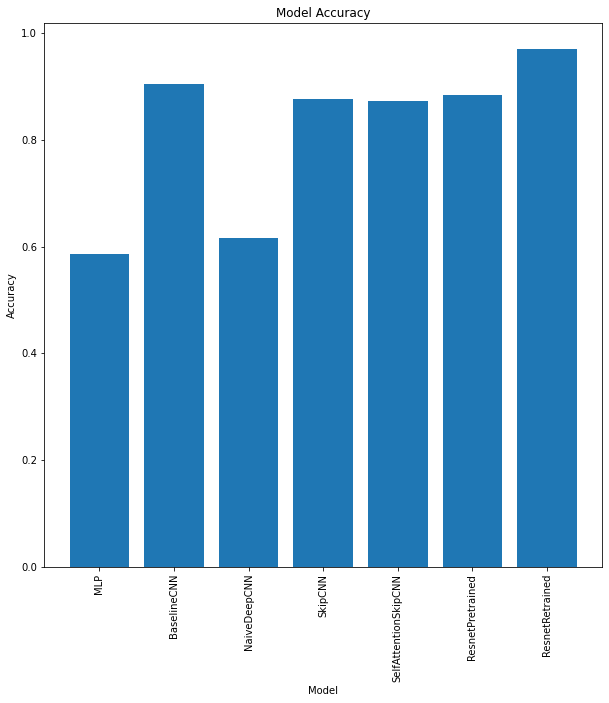

In [50]:
model_chkpts = None
if use_checkpoint:
    model_chkpts = [baselineMLP_chkpt, baselineCNN_chkpt, naiveDeepCNN_chkpt, skipCNN_chkpt,
                         saSkipCNN_chkpt, resnetPretrained_chkpt, resnetRetrained_chkpt]
    
    
evaluate_models([baselineMLP, baselineCNN, naiveDeepCNN, skipCNN, saSkipCNN, resnetPretrained, resnetRetrained], model_chkpts,
                ["MLP", "BaselineCNN", "NaiveDeepCNN", "SkipCNN", "SelfAttentionSkipCNN", "ResnetPretrained", "ResnetRetrained"],
                test_dataset)

We used two evaluation metrics here. The first and more common one is accuracy. This metric tells us how good our model is in general. This is the main metric used to evaluate image classifiers. It is simply the number of correctly classified images over the total number of images. A retrained resnet architecture provided the best results which is a bit expected since this is a deep network with tons of research behind it and made by experts in the field. It is also the deepest network explored in this project which can somehow tells us that making networks deeper really does help. The models we trained however aren't too far off with the CNN-based models along with the pre-trained Resnet being in the same ballpark. The BaselineCNN was already performing very well and as such there were little to no improvements when SkipCNN and SelfAttentionSkipCNN were used. The MLP and the NaiveDeepCNN performed the worst as expected.


The second metric we used was F1 score (a metric whose value is from 0 to 1 with 1 being the highest). F1 score is a combination of precision and recall and basically tells us how good we are at identifying a certain class. The reason why we added this is because we want to know which classes the model has a hard time identifying or is confused with. 

It turns out that the model has a hard time identifying goat and sheep the most. This is quite understandable as a goat really looks like a sheep. Moreover, since our images hardly contain information about the actual size of the animal, a goat can be mistaken as a cow. While it is easy for us to differentiate a goat and a cow in real life thanks to the size difference, they can be mistaken for each other if we base it only on how they look like.

To add some explainability to our models, let's try visualizing the first activation layers and see what part of the image is being given importance. The pixels that are activated are the ones that provide values to our network and therefore are the ones that are mainly used for deciding. Note here that we're going to show only a couple of channels from the first layers so that the image is not yet downsampled. Also, the `show_activation` function below is not fully-compatible for all networks (only applicable for custom CNN-based models).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


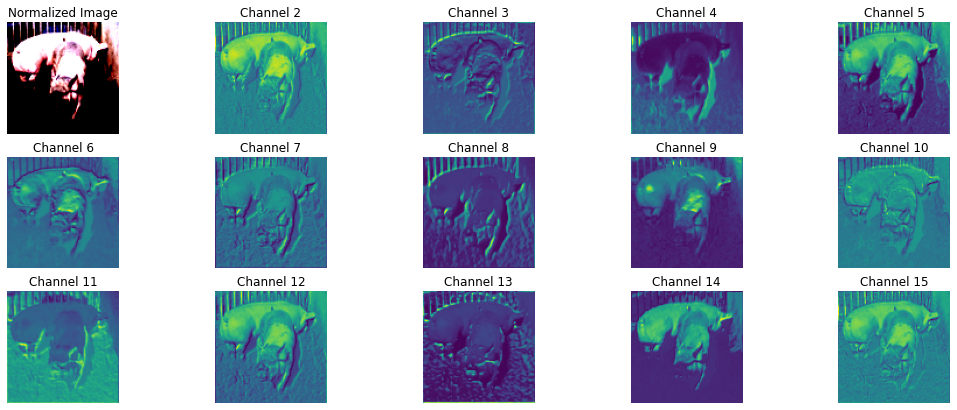

In [51]:
image, _ = next(iter(DataLoader(val_dataset, batch_size = 1, shuffle = True)))
show_activation(skipCNN, image[0])

We can see that the head of the animal is given a lot of emphasis (yellow patches). This is inline with how we actually determine the type of animal. Other channels focus on specific body parts like the body or the beak.

## IV. Conclusions and Future Work


From this project we see that CNNs are really good at image classification tasks. Even shallow and narrow CNNs can already provide good accuracy score with just some simple tuning. Other network architectures may also improve our scores but these aren't always guaranteed. 

While in this project we have successfully created an image classifier for livestock animals, in reality a robot should not only be able to classify these animals but also know where exactly they are in the picture which can be done through image segmentation. Additionally, the number of classes an image can be classified to must be increased as a robot must also know how to identify a water bucket or a bag of chicken feed.

## Miscellaneous

This part is just some miscellaneous stuff that I think might be interesting. A helper function was added to accept an image and use a model to predict its class. Feel free to try out a picture you'd like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted:  chicken


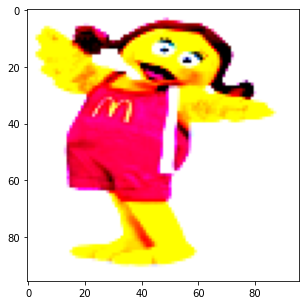

In [52]:
image_path = "sample_image.png"
predict_image(skipCNN, image_path, test_transforms, class_dict)